## Libraries

In [1]:
import random
import pandas as pd
import numpy as np
from namedlist import namedlist
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor


from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import AdaBoostRegressor

from data_manipulation import *
from data_preprocessing import *
from best_feature_extraction import *

warnings.filterwarnings('ignore')
%matplotlib inline

## Locating and Unzipping data files

In [2]:
# data directory
data_dir = '.\data'
# extract_files() is a function in data_manipulation module that simply unzips files
extract_files(data_dir)

## Loading sales data 

In [3]:
data = extract_sales_data(data_dir)
data.iloc[:5,:10]# head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384
2015-08-03 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-03 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Weekly sales

In [4]:
"""
Note that the data in raw form is at hourly resolution.
In this resolution, too many data points are missing.
While we believe amenities features can predict sales, 
predicting at hourly scale is a big ask.
Therefore, we accumulate data over a week. 
"""
weekly_sales = extract_weekly_sales(data)
# weekly_sales.iloc[[0,1,2,3,95,96,97,98], :10]
weekly_sales.iloc[-5:,:10]# .head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384
week_numb,,,,,,,,,,
94,990.0,30.0,5430.0,13260.0,1650.0,3420.0,1530.0,4830.0,0.0,4650.0
95,90.0,0.0,4260.0,7980.0,2220.0,1020.0,750.0,6630.0,0.0,6450.0
96,390.0,630.0,3270.0,6690.0,1560.0,2190.0,720.0,2670.0,0.0,5010.0
97,870.0,270.0,3360.0,6270.0,1110.0,1500.0,2010.0,2760.0,0.0,3990.0
98,900.0,1050.0,3360.0,8490.0,1050.0,1470.0,2370.0,5730.0,0.0,3570.0


In [5]:
# cumulative_weekly_sales = weekly_sales.cumsum()

# weeks_in_operation = pd.notna(weekly_sales).cumsum()# .sum(axis = 1).to_frame()
# avg_weekly_sales_across_time = cumulative_weekly_sales / weeks_in_operation


In [6]:
# boxplot = avg_weekly_sales_across_time.T.iloc[:,range(2,99,6)].boxplot()
# plt.xlabel('Week Number')
# plt.ylabel('Mean weekly sales across stores')
# plt.title('Mean weekly sales across time')
# plt.show()

### Trend in Sales and new stores

In [7]:
"""
In order to design a target variable that can be explained with the amenities around POS,
it is imperative to understand the relative trends in the sales. 
"""
# We compute a time series of overall sales per week across all the stores. 
total_sales_across_time = weekly_sales.sum(axis=1)
"""
We compute the total number of stores in operation at a particular week. 
We assume that once a sale is made at a store, it has started its operation
and does not halt its operation. (*a store is never closed*).
See demarcate_biz_start() function in data_manipulation module for 
details on how we demaracate business start date. 
"""
numb_stores_across_time = pd.notna(weekly_sales).sum(axis=1)

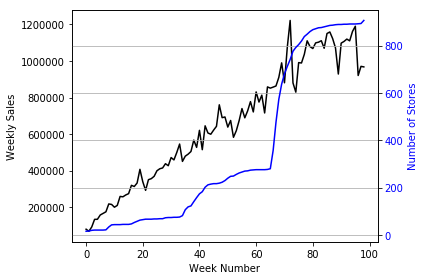

In [8]:
"""
We plot 2 time series;
firstly, the total sales across all stores and
secondly, the number of stores in operation. 
From the figure, we find that the our sales operations are successful
and management opens up a lot of new stores to cope up with the sales. 
"""

fig, ax1 = plt.subplots()

color = 'black'
ax1.set_xlabel('Week Number')
ax1.set_ylabel('Weekly Sales', color=color)
ax1.plot(total_sales_across_time.index, total_sales_across_time, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('Number of Stores', color=color)  # we already handled the x-label with ax1
ax2.plot(total_sales_across_time.index, numb_stores_across_time, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.grid()
plt.show()

In [9]:
fig.savefig('sales_and_stores.png')

### Sales trend of Stores

In [10]:
"""
While we observe huge increase in the overall sales, 
that might be deceptive and might owe to larger number of
stores.
To understand it, we take a look at the sales trend in individual stores. 
"""

# seed for reproducibility. 

random.seed(0)

# stores list
stores = weekly_sales.columns.tolist()
# Pick random stores
selected_stores = random.sample(stores, 5)
# Fixing the store_code for reproducibility 
selected_stores = [75053] # [selected_stores[0]]

In [11]:
# Computing overall mean weekly sales of the selected store
mean_value = pd.DataFrame([weekly_sales[selected_stores].mean()] * 99, index=weekly_sales.index, columns=selected_stores)
"""
Simple arithmetic mean does not indicate any trends and just averages any trends out.
If the trends change, we should be interested and our target variable should be based 
on recent trends.
exponential moving average is one such measure that can capture trends by weighting
recent samples more. and Apart from 
with ewma(t) = alpha * x(t) + (1-alpha) * ewma(t-1), alpha is a design choice.
Roughly, a measurement (1/alpha) time units (weeks in this case) in the past 
get a weight that is (1/3) of the weight of the most recent measurement. 
We set alpha=0.2, implying impact of weeks older than 5 from now is less than (1/3) of current week. . 
"""
exp_mean_value = weekly_sales[selected_stores].ewm(alpha = 0.2, adjust=False).mean()

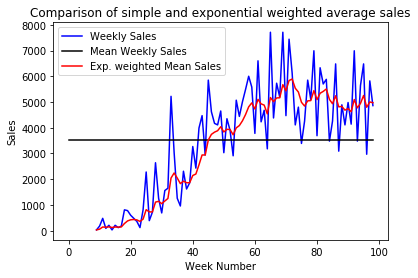

In [12]:
### Plotting weekly sales in the store, overall mean and ewma. 

fig, ax = plt.subplots( nrows=1, ncols=1 ) 

ax.plot(weekly_sales[selected_stores], color='blue')
ax.plot(mean_value, color='black')
ax.plot(exp_mean_value, color='red')

ax.legend(['Weekly Sales', 'Mean Weekly Sales', 'Exp. weighted Mean Sales'], loc='upper left')

plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.title('Comparison of simple and exponential weighted average sales')
plt.show()

In [13]:
fig.savefig('sales_trends_at_store.png')

In [14]:
### Selecting target

"""Based on these observations, find that exponentially weighted average tracks the recent trend and hence can be a good target. 
This measure reflect recent trends while also being able to track steady sales. """

'Based on these observations, find that exponentially weighted average tracks the recent trend and hence can be a good target. \nThis measure reflect recent trends while also being able to track steady sales. '

In [15]:
""" ewma can be susceptible to initial conditions and it takes a while to get away with the effects of initial conditions.
Based on this, stores new into the operation can have quite faulty sales estimates """
# Finding the least time an arbitrary store started operation. 
print(weekly_sales.notna().sum().min())

1


In [16]:
"""
There is at least one stores that opened just 1 week prior to the data close and hence would be biased by initial values. 
We can circumvent it simply by backward filling the weekly sales data frame by 15 places 
to subside the effects of initialization.  
with alpha = 0.2, the weight of the 15th value preceeding the current value is 0.8 ^ 15 ~ 0.035 times the current weight.
 """

'\nThere is at least one stores that opened just 1 week prior to the data close and hence would be biased by initial values. \nWe can circumvent it simply by backward filling the weekly sales data frame by 15 places \nto subside the effects of initialization.  \nwith alpha = 0.2, the weight of the 15th value preceeding the current value is 0.8 ^ 15 ~ 0.035 times the current weight.\n '

In [17]:
weekly_sales.fillna(method = 'bfill', limit = 15, inplace = True)

In [18]:
## Computing ewm and taking the last value that would server as our target variable. 

sales_volume = weekly_sales.ewm(alpha = 0.2, adjust=False).mean().iloc[-1]

## Data preparation for ML

### Loading JSON data


In [19]:
# extracting json data. See function extract_json_data() in module data_manipulation
json_data = extract_json_data(data_dir)

### Feature extraction

In [20]:
# Creating a class instance for getting processed data for machine learning
processed_data = DataSet(json_data)
# This function extracts the dataframe
features_df = processed_data.extract_dataframe()
# This returns the list of amenities that we are considering to rate for sales
# amenities = processed_data.extract_amenities()

### Combining features with the sales volume (target)

In [21]:
df = merge_data(features_df, sales_volume)
df.head()

,accounting,airport,amusement_park,aquarium,art_gallery,atm,bakery,bank,bar,beauty_salon,...,has_insurance_agency_and_has_pet_store,has_insurance_agency_and_has_bakery,has_insurance_agency_and_has_travel_agency,has_plumber_and_has_pet_store,has_plumber_and_has_bakery,has_plumber_and_has_travel_agency,has_pet_store_and_has_bakery,has_pet_store_and_has_travel_agency,has_bakery_and_has_travel_agency,sales_volume
store_code,,,,,,,,,,,,,,,,,,,,,
10055,3,0,0,0,1,1,3,3,1,4,...,0,1,1,0,0,0,0,0,1,589.265167
10077,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,378.266067
10079,1,0,0,0,0,3,3,1,4,4,...,0,1,1,0,0,0,0,0,1,4115.069751
10086,0,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,1743.755454
10111,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1374.441237


In [22]:
df.shape

(546, 3795)

### Creating a train-test split

In [23]:
# stratefied sampling; see function train_test_split() in module best_feature_extraction
train, test = train_test_split(df, test_ratio = 0.2, n_splits=1, best_split = False) 

### Extracting best features using different models

In [24]:
"""
A dictionary of models_name and models_sklearn representation.
We use these models in our work. 
"""
models = {'LinearRegression':LinearRegression(), 
          'DecisionTreeRegressor':DecisionTreeRegressor(random_state=25), 
          # 'RandomForestRegressor':RandomForestRegressor(), 
          # 'AdaBoostRegressor':AdaBoostRegressor(), 
          # 'SVR':svm.SVR(),
          # 'SVR(kernel="linear")':svm.SVR(kernel="linear"),
         }

In [25]:
# Extracting features using base models
models_features = feature_extraction(models, train)



******************
LinearRegression
******************
adding_variable: has_university_and_has_gas_station
adding_variable: cafe
adding_variable: has_university_and_has_bicycle_store
adding_variable: subway_station_rating_count
adding_variable: museum_rating_count


******************
DecisionTreeRegressor
******************
adding_variable: university_rating_count
adding_variable: has_university_and_has_train_station
adding_variable: has_university_and_has_laundry
adding_variable: has_movie_theater_and_has_park
adding_variable: park


In [26]:
# Displaying feature statistics

# extracted features using linear regression. index 0 stores linear regression
features = models_features[0].extracted_features
"feature_statistics() is a function that displays statistics on features; see in module data_manipulation"
feature_statistics(train, features)

mean          std  \
has_university_and_has_gas_station   False   454.527973   773.272675   
                                     True   2804.323549  3429.782539   
cafe                                 False   375.918164   758.930580   
                                     True    732.032587  1469.066132   
has_university_and_has_bicycle_store False   605.487759  1287.065591   
                                     True    604.064780   908.967155   
subway_station_rating_count          False   566.803619  1171.138876   
                                     True   4777.327180  3840.307321   
museum_rating_count                  False   631.907067  1371.123747   
                                     True    496.106960   743.201978   

                                            sample size  
has_university_and_has_gas_station   False        408.0  
                                     True          28.0  
cafe                                 False        155.0  
                                     True         281.0  
has_university_and_has_bicycle_store False        419.0  
                                     True          17.0  
subway_station_rating_count          False        432.0  
                                     True           4.0  
museum_rating_count                  False        351.0  
                                     True          85.0

In [27]:
# Statistics on Decision trees

features = models_features[1].extracted_features
feature_statistics(train, features)

mean          std  \
university_rating_count              False   481.300045   934.552947   
                                     True   1944.047413  2816.594774   
has_university_and_has_train_station False   557.022154  1171.919631   
                                     True   1474.709671  2349.716792   
has_university_and_has_laundry       False   427.910480   739.738444   
                                     True   2704.366444  3132.254148   
has_movie_theater_and_has_park       False   598.252487  1315.596901   
                                     True    664.856483   858.687433   
park                                 False   470.600574   979.688002   
                                     True    956.440424  1788.025428   

                                            sample size  
university_rating_count              False        399.0  
                                     True          37.0  
has_university_and_has_train_station False        413.0  
                                     True          23.0  
has_university_and_has_laundry       False        402.0  
                                     True          34.0  
has_movie_theater_and_has_park       False        389.0  
                                     True          47.0  
park                                 False        315.0  
                                     True         121.0

### Predicting in the log scale

### Log scale

The features extracted in the linear scale are susceptible to learning features that can discriminate stores with very high sales. Since the stores with very high sales are not well represented and very well be outliers. We need to predict in the log space. 

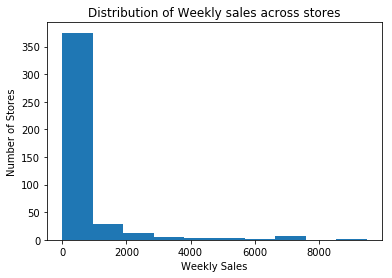

In [28]:
plt.hist(train.sales_volume)
plt.xlabel('Weekly Sales')
plt.ylabel('Number of Stores')
plt.title('Distribution of Weekly sales across stores')
plt.show()

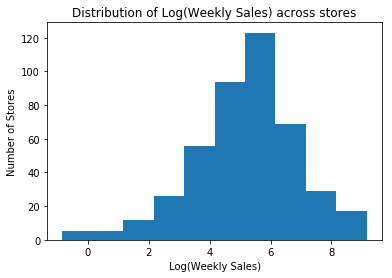

In [29]:
plt.hist(take_log(train.sales_volume))
plt.xlabel('Log(Weekly Sales)')
plt.ylabel('Number of Stores')
plt.title('Distribution of Log(Weekly Sales) across stores')
plt.show()

In [30]:
# taking log of the target variable
train['sales_volume'] = take_log(train['sales_volume'])

In [31]:
models_features = feature_extraction(models, train )



******************
LinearRegression
******************
adding_variable: pharmacy
adding_variable: has_city_hall_and_has_electrician
adding_variable: cafe_rating_count
adding_variable: lodging_avg_rating
adding_variable: has_pharmacy_and_has_insurance_agency


******************
DecisionTreeRegressor
******************
adding_variable: cafe
adding_variable: has_shopping_mall_and_has_car_dealer
adding_variable: has_hardware_store_and_has_fire_station
adding_variable: has_spa_and_has_train_station
adding_variable: has_university_and_has_post_office


In [32]:
train['sales_volume'] = take_exp(train['sales_volume'])

In [33]:
features = models_features[0].extracted_features
feature_statistics(train, features)

mean          std  \
pharmacy                              False  326.686917   631.067557   
                                      True   750.146765  1483.150540   
has_city_hall_and_has_electrician     False  644.765663  1331.057721   
                                      True   263.668846   447.788775   
cafe_rating_count                     False  401.927347   825.529323   
                                      True   740.584404  1485.254887   
lodging_avg_rating                    False  511.730499   911.771621   
                                      True   681.955393  1503.715420   
has_pharmacy_and_has_insurance_agency False  383.901440   739.852586   
                                      True   926.527531  1736.874074   

                                             sample size  
pharmacy                              False        149.0  
                                      True         287.0  
has_city_hall_and_has_electrician     False        391.0  
                                      True          45.0  
cafe_rating_count                     False        174.0  
                                      True         262.0  
lodging_avg_rating                    False        196.0  
                                      True         240.0  
has_pharmacy_and_has_insurance_agency False        258.0  
                                      True         178.0

In [34]:
features = models_features[1].extracted_features
feature_statistics(train, features)

mean          std  \
cafe                                    False   375.918164   758.930580   
                                        True    732.032587  1469.066132   
has_shopping_mall_and_has_car_dealer    False   566.786865  1256.965312   
                                        True   1022.176030  1392.496883   
has_hardware_store_and_has_fire_station False   604.117549  1274.625263   
                                        True    795.191160  1357.638648   
has_spa_and_has_train_station           False   562.012523  1215.041948   
                                        True    817.837010  1520.081688   
has_university_and_has_post_office      False   437.446560   752.416111   
                                        True   2102.032288  2951.869415   

                                               sample size  
cafe                                    False        155.0  
                                        True         281.0  
has_shopping_mall_and_has_car_dealer    False        399.0  
                                        True          37.0  
has_hardware_store_and_has_fire_station False        433.0  
                                        True           3.0  
has_spa_and_has_train_station           False        362.0  
                                        True          74.0  
has_university_and_has_post_office      False        392.0  
                                        True          44.0

In [78]:
"""
Features extracted from either linear regression or Decision trees;
trained over in linear or log target variable, 
we find that unstable variables are extracted. 
To circumvent it, we use bagging with simple models to extract features. 
"""

'\nFeatures extracted from either linear regression or Decision trees;\ntrained over in linear or log target variable, \nwe find that unstable variables are extracted. \n'

###  Extracting features using Bagging followed by simple models (linear output)

In [35]:
train, test = train_test_split(df, test_ratio = 0.2, n_splits=1, best_split = False) 

In [36]:
# See function feature_extraction() in module best_feature_extraction for info into how bagging is done. 
models_features_linear = feature_extraction(models, train, precede_bagging=True)



******************
LinearRegression
******************
------------------
Bagging Features
------------------
adding_variable: cafe
adding_variable: book_store
adding_variable: laundry
adding_variable: laundry_avg_rating
adding_variable: electronics_store
adding_variable: has_gas_station_and_has_laundry
adding_variable: has_shopping_mall_and_has_locksmith
adding_variable: has_shopping_mall_and_has_movie_theater
adding_variable: doctor_rating_count
adding_variable: cafe_avg_rating
adding_variable: bus_station
adding_variable: local_government_office_avg_rating
adding_variable: has_city_hall_and_has_lodging
adding_variable: has_gas_station_and_has_museum
adding_variable: book_store_avg_rating
------------------
Final Features
------------------
adding_variable: cafe
adding_variable: book_store
adding_variable: laundry
adding_variable: laundry_avg_rating
adding_variable: electronics_store


******************
DecisionTreeRegressor
******************
------------------
Bagging Features
-

In [37]:
features = models_features_linear[0].extracted_features
feature_statistics(train, features)

mean          std  sample size
cafe               False   375.918164   758.930580        155.0
                   True    732.032587  1469.066132        281.0
book_store         False   427.573421   766.522279        295.0
                   True    977.548318  1897.469225        141.0
laundry            False   411.328431   719.168257        303.0
                   True   1047.638779  1969.528232        133.0
laundry_avg_rating False   605.799187  1327.960716        366.0
                   True    603.513855   947.781582         70.0
electronics_store  False   424.356880   791.338161        134.0
                   True    685.776988  1430.589551        302.0

In [38]:
features = models_features_linear[1].extracted_features
feature_statistics(train, features)

mean          std  sample size
real_estate_agency False   457.707912   993.203752         81.0
                   True    639.138398  1328.272694        355.0
pet_store          False   575.900539  1248.857872        411.0
                   True   1090.934026  1580.431042         25.0

###  Extracting features using Bagging followed by simple models (log output)

In [39]:
# Same bagging but output is log 
train, test = train_test_split(df, test_ratio = 0.2, n_splits=1, best_split = False) 
train['sales_volume'], test['sales_volume'] = take_log(train['sales_volume']), take_log(test['sales_volume'])

In [40]:
models_features_log = feature_extraction(models, train, precede_bagging=True)



******************
LinearRegression
******************
------------------
Bagging Features
------------------
adding_variable: pharmacy
adding_variable: has_city_hall_and_has_electrician
adding_variable: cafe_rating_count
adding_variable: lodging_avg_rating
adding_variable: has_pharmacy_and_has_insurance_agency
adding_variable: has_meal_takeaway_and_has_lodging
adding_variable: has_bank_and_has_museum
adding_variable: has_jewelry_store_and_has_storage
adding_variable: has_cemetery_and_has_locksmith
adding_variable: has_home_goods_store_and_has_plumber
adding_variable: has_car_dealer_and_has_storage
adding_variable: has_gas_station_and_has_park
adding_variable: has_dentist_and_has_plumber
adding_variable: liquor_store
adding_variable: has_courthouse_and_has_hardware_store
------------------
Final Features
------------------
adding_variable: pharmacy
adding_variable: has_city_hall_and_has_electrician
adding_variable: cafe_rating_count
adding_variable: lodging_avg_rating
adding_variable

In [41]:
train['sales_volume'], test['sales_volume'] = take_exp(train['sales_volume']), take_exp(test['sales_volume'])

In [42]:
features = models_features_log[0].extracted_features
feature_statistics(train, features)

mean          std  \
pharmacy                              False  326.686917   631.067557   
                                      True   750.146765  1483.150540   
has_city_hall_and_has_electrician     False  644.765663  1331.057721   
                                      True   263.668846   447.788775   
cafe_rating_count                     False  401.927347   825.529323   
                                      True   740.584404  1485.254887   
lodging_avg_rating                    False  511.730499   911.771621   
                                      True   681.955393  1503.715420   
has_pharmacy_and_has_insurance_agency False  383.901440   739.852586   
                                      True   926.527531  1736.874074   

                                             sample size  
pharmacy                              False        149.0  
                                      True         287.0  
has_city_hall_and_has_electrician     False        391.0  
                                      True          45.0  
cafe_rating_count                     False        174.0  
                                      True         262.0  
lodging_avg_rating                    False        196.0  
                                      True         240.0  
has_pharmacy_and_has_insurance_agency False        258.0  
                                      True         178.0

In [43]:
features = models_features_log[1].extracted_features
feature_statistics(train, features)

mean          std  \
cafe                                         False   375.918164   758.930580   
                                             True    732.032587  1469.066132   
has_shopping_mall_and_has_car_dealer         False   566.786865  1256.965312   
                                             True   1022.176030  1392.496883   
has_meal_takeaway_and_has_roofing_contractor False   604.268182  1280.750321   
                                             True    640.521383  1076.292659   

                                                    sample size  
cafe                                         False        155.0  
                                             True         281.0  
has_shopping_mall_and_has_car_dealer         False        399.0  
                                             True          37.0  
has_meal_takeaway_and_has_roofing_contractor False        422.0  
                                             True          14.0

## model evaluation

So, we have trained 4 models, let us evaluate them along with a base model to make conclusions about best model. 
We define base model as one which predicts mean of the target variable in training set. 

In [44]:
train, test = train_test_split(df, test_ratio = 0.2, n_splits=1, best_split = False) 

In [47]:
model_performance = []

In [48]:
# Base model
model_performance.append(['base model', *compute_rmse_base(train, test)])

In [49]:
# Linear Regression (Linear output)

model = models_features_linear[0].sklearn_form
features = models_features_linear[0].extracted_features

model_performance.append(['linear regression - Y', *compute_rmse(model, features, train, test)])

In [50]:
# Decision Trees (Linear output)
model = models_features_linear[1].sklearn_form
features = models_features_linear[1].extracted_features

model_performance.append(['Decision Tree - Y', *compute_rmse(model, features, train, test)])

In [51]:
# Linear Regression (Log output)
model = models_features_log[0].sklearn_form
features = models_features_log[0].extracted_features

model_performance.append(['linear regression - log(Y)', *compute_rmse(model, features, train, test, is_log=True)])

In [52]:
# Decision Trees (Log output)
model = models_features_log[1].sklearn_form
features = models_features_log[1].extracted_features

model_performance.append(['Decision Tree - log(Y)', *compute_rmse(model, features, train, test, is_log=True)])

In [53]:
# A data frame showing the performance of all four models. 
performance_df = pd.DataFrame(model_performance, columns=['Model','Train RMSE', 'Test RMSE'])
performance_df

,Model,Train RMSE,Test RMSE
0,base model,1272.190545,1064.677986
1,linear regression - Y,1041.933552,881.515406
2,Decision Tree - Y,773.581141,1116.455479
3,linear regression - log(Y),1217.922197,934.088890
4,Decision Tree - log(Y),1056.802804,1033.520525


## Best Model

Linear regression fitting linear sales volume is determined to be the best model. 

In [54]:
model = models_features_linear[0].sklearn_form
features = models_features_linear[0].extracted_features

model.fit(train[features], train['sales_volume'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
# A dataframe showing the regression coefficients of best model
model_coefs = pd.Series(model.coef_, index=features).to_frame()
model_coefs.columns = ['Regression Coefficient']

In [59]:
model_coefs

,Regression Coefficient
cafe,183.472003
book_store,-154.566553
laundry,582.453222
laundry_avg_rating,-232.807086
electronics_store,-96.292089


In [61]:
feature_statistics(train, features)

mean          std  sample size
cafe               False   375.918164   758.930580        155.0
                   True    732.032587  1469.066132        281.0
book_store         False   427.573421   766.522279        295.0
                   True    977.548318  1897.469225        141.0
laundry            False   411.328431   719.168257        303.0
                   True   1047.638779  1969.528232        133.0
laundry_avg_rating False   605.799187  1327.960716        366.0
                   True    603.513855   947.781582         70.0
electronics_store  False   424.356880   791.338161        134.0
                   True    685.776988  1430.589551        302.0

In [63]:
feature_statistics(test, features)

mean          std  sample size
cafe               False  382.700567   608.960803         39.0
                   True   665.161370  1244.471118         71.0
book_store         False  370.218079   588.370872         74.0
                   True   965.434488  1609.422190         36.0
laundry            False  469.255670   863.191482         82.0
                   True   845.457658  1505.576014         28.0
laundry_avg_rating False  532.067461  1093.217190         94.0
                   True   758.589877   918.750479         16.0
electronics_store  False  384.867618   520.003052         35.0
                   True   649.085503  1239.278226         75.0